## Modeling single input triples 

In this document, I will model triples with single inputs. I begin by preparing the data, as I need unique names for entities and relations. Then I move on to the models. I decided to use the **[RESCAL](https://icml.cc/2011/papers/438_icmlpaper.pdf)** since it performed better for multiple input data.In the beginning an example of a model with basic settings using the `pipeline()` function from the [PyKeen](https://pykeen.readthedocs.io/en/stable/index.html) package is made. Then, using the same package's `hpo_pipeline()`, I tune the hyperparameters. Finally, I build the final model with the best parameters, make some predictions, and evaluate it.

In [2]:
# for loding and saving the files 
import pickle 
import os 

# creating unique names 
import pandas as pd
import numpy as np
import re

# splitting the data into training, testing, validation
from sklearn.model_selection import train_test_split

# PyKeen packages 
from pykeen.triples import TriplesFactory
from pykeen.models import RESCAL
from pykeen.pipeline import pipeline
from pykeen.evaluation import RankBasedEvaluator
from pykeen.hpo import hpo_pipeline
from pykeen import predict

# for emmbeding visualisation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.graph_objects as go

---

## 1. Data preparation 

In this section, I need to make sure that the entities and relations have unique names. I do so by merging the words together. Then I divide the data into train, test and validation sets. 

In [3]:
# loading the file 

# indicating the directory where the file is located  
directory_triples = "C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/triples"
os.chdir(directory_triples)

# opening the picke file with the triples 
with open('triples_single_df.pkl', 'rb') as file:
    triples_single_df = pickle.load(file)
    
# showing the data frame 
triples_single_df

head  \
0          ObjectQ, VectorTessellationA, NominalA   
1      FieldQ, VectorTessellationA, PlainNominalA   
2          ObjectQ, VectorTessellationA, NominalA   
3                     ObjectQ, VectorRegionA, ERA   
4    ObjectQ, VectorTessellationA, PlainIntervalA   
..                                            ...   
620         ObjectQ, PlainVectorRegionA, NominalA   
621    ObjectQ, PlainVectorRegionA, PlainNominalA   
622                  FieldQ, RasterA, PlainRatioA   
623                ObjectQ, PointA, PlainNominalA   
624                          ObjectQ, PointA, ERA   

                          relation                               tail  
0    IntersectDissolveField2Object        ObjectQ, VectorRegionA, ERA  
1    IntersectDissolveField2Object        ObjectQ, VectorRegionA, ERA  
2          SpatialJoinSumTessRatio  ObjectQ, VectorTessellationA, ERA  
3          SpatialJoinSumTessRatio  ObjectQ, VectorTessellationA, ERA  
4          SpatialJoinSumTessRatio  ObjectQ, VectorTessellationA, ERA  
..                             ...                                ...  
620               makePointObjects     ObjectQ, PointA, PlainNominalA  
621        ZonalStatisticsSumField   ObjectQ, PlainVectorRegionA, ERA  
622        ZonalStatisticsSumField   ObjectQ, PlainVectorRegionA, ERA  
623              addObjectCapacity               ObjectQ, PointA, ERA  
624                  KernelDensity       FieldQ, RasterA, PlainRatioA  

[625 rows x 3 columns]

In [4]:
# get values of heads 
values_head = triples_single_df['head']

# get values of tails 
values_tail = triples_single_df['tail']


# create a dictionary to map unique values to unique names for head 
unique_names_head = {value: ''.join(re.findall(r'[A-Z]+[a-z]*', str(value))) for value in values_head}

# Create a dictionary to map unique values to unique names for tail 
unique_names_tail = {value: ''.join(re.findall(r'[A-Z]+[a-z]*', str(value))) for value in values_tail}

#create df with unique values 
unique_df = triples_single_df

# Replace the values in the 'head' column with the unique names
unique_df['head'] = unique_df['head'].apply(str).replace(unique_names_head)

# Replace the values in the 'tail' column with the unique names 
unique_df['tail'] = unique_df['tail'].apply(str).replace(unique_names_tail)

unique_df

head                       relation  \
0          ObjectQVectorTessellationANominalA  IntersectDissolveField2Object   
1      FieldQVectorTessellationAPlainNominalA  IntersectDissolveField2Object   
2          ObjectQVectorTessellationANominalA        SpatialJoinSumTessRatio   
3                     ObjectQVectorRegionAERA        SpatialJoinSumTessRatio   
4    ObjectQVectorTessellationAPlainIntervalA        SpatialJoinSumTessRatio   
..                                        ...                            ...   
620         ObjectQPlainVectorRegionANominalA               makePointObjects   
621    ObjectQPlainVectorRegionAPlainNominalA        ZonalStatisticsSumField   
622                  FieldQRasterAPlainRatioA        ZonalStatisticsSumField   
623                ObjectQPointAPlainNominalA              addObjectCapacity   
624                          ObjectQPointAERA                  KernelDensity   

                              tail  
0          ObjectQVectorRegionAERA  
1          ObjectQVectorRegionAERA  
2    ObjectQVectorTessellationAERA  
3    ObjectQVectorTessellationAERA  
4    ObjectQVectorTessellationAERA  
..                             ...  
620     ObjectQPointAPlainNominalA  
621   ObjectQPlainVectorRegionAERA  
622   ObjectQPlainVectorRegionAERA  
623               ObjectQPointAERA  
624       FieldQRasterAPlainRatioA  

[625 rows x 3 columns]

In [4]:
unique_df.duplicated(subset=['head', 'relation', 'tail'])

0      False
1      False
2      False
3      False
4      False
       ...  
620     True
621     True
622     True
623     True
624     True
Length: 625, dtype: bool

Since I removed duplicates I will now move to diciding the data into training, validation and testing 

In [5]:
factory_single = TriplesFactory.from_labeled_triples(unique_df[["head", "relation", "tail"]].astype(str).values)
factory_single

TriplesFactory(num_entities=37, num_relations=30, create_inverse_triples=False, num_triples=161)

In [6]:
random_seed = 42
test_size = 0.1  # percentage of triples for testing
val_size = 0.1  # percentage of triples for validation

# splitting the triples into training and the rest 
train_triples, remaining_triples = train_test_split(factory_single.mapped_triples, test_size=test_size+val_size, random_state=random_seed)

# splitting the rest triples into test and validation sets 
test_triples, val_triples = train_test_split(remaining_triples, test_size=val_size/(test_size+val_size), random_state=random_seed)

# extracting entity_to_id and relation_to_id mappings 
entity_to_id = factory_single.entity_to_id
relation_to_id = factory_single.relation_to_id

# creating factories for each split
training_factory = TriplesFactory(train_triples, entity_to_id, relation_to_id)
testing_factory = TriplesFactory(test_triples, entity_to_id, relation_to_id)
validation_factory = TriplesFactory(val_triples, entity_to_id, relation_to_id)

In [7]:
training_factory


TriplesFactory(num_entities=37, num_relations=30, create_inverse_triples=False, num_triples=128)

In [8]:
testing_factory

TriplesFactory(num_entities=37, num_relations=30, create_inverse_triples=False, num_triples=16)

In [9]:
validation_factory

TriplesFactory(num_entities=37, num_relations=30, create_inverse_triples=False, num_triples=17)

---

## 2. RESCAL model

This section consists of an example of the basic RESCAL model, the hyperparameter tuning for it and later the evaluation with the example of prediction.

### 2.1 RESCAL model - simple example 

Now, I'll create an example model with basic parameters. However, I will not go into too much detail about it. This step only serves to demonstrate whether or not the hyperparameter tuning improved the model.

In [12]:
# generating the first model 
model_single_basic = pipeline(
    training=training_factory,
    testing=testing_factory,
    validation = validation_factory, 
    model= "RESCAL",
    training_loop = "slcwa",
    negative_sampler='basic',
    negative_sampler_kwargs=dict(
        filtered=True,    
    ),
    random_seed=42)

No cuda devices were available. The model runs on CPU


Training epochs on cpu:   0%|          | 0/5 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/16.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.05s seconds


In [17]:
# setting directory to save the model and all its parameters 
dir_model_single = "C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_single_RESCAL"

In [22]:

# saving the model_multiple_basic
model_single_basic.save_to_directory(dir_model_single)

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=37, num_relations=30, create_inverse_triples=False, num_triples=128) to file:///C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_single_RESCAL/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_single_RESCAL


<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

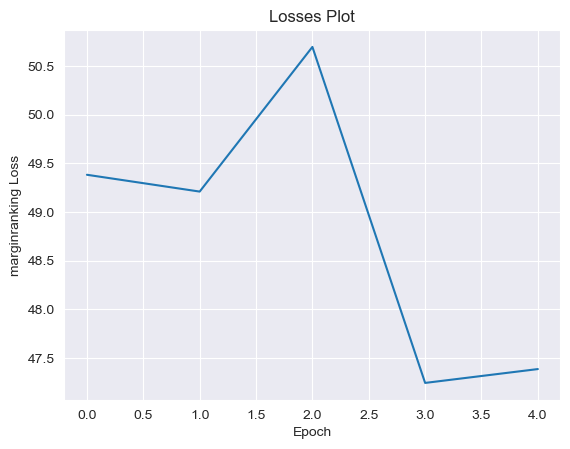

In [13]:
model_single_basic.plot_losses()

### 2.2 RESCAL model - hyperparameter tuning

In this section, I tune the RESCAL model's hyperparameters. Some of the intervals for which the parameters are tuned were taken from the Pykeen website and adjusted to the size of the data set, and the hpo_pipeline automatically tunes for them in some cases. Then I take the best parameters produced and apply them to the standard pipeline. 

In [14]:
hpo_pipeline_result_single_R = hpo_pipeline(
    n_trials=30,
    training=training_factory,
    testing=testing_factory,
    validation = validation_factory, 
    model= "RESCAL",
    lr_scheduler='ExponentialLR',
    lr_scheduler_kwargs_ranges=dict(
        gamma=dict(type=float, low=0.8, high=1.0),
    ),
    training_loop = "slcwa",
    negative_sampler='basic',
    negative_sampler_kwargs=dict(
        filtered=True,    
    )    
)

[I 2023-06-28 12:20:35,571] A new study created in memory with name: no-name-64e47914-448b-4cd7-9cee-7abf8a81f583
INFO:pykeen.hpo.hpo:Using model: <class 'pykeen.models.unimodal.rescal.RESCAL'>
INFO:pykeen.hpo.hpo:Using loss: <class 'pykeen.losses.MarginRankingLoss'>
INFO:pykeen.hpo.hpo:Using regularizer: <class 'pykeen.regularizers.LpRegularizer'>
INFO:pykeen.hpo.hpo:Using optimizer: <class 'torch.optim.adam.Adam'>
INFO:pykeen.hpo.hpo:Using lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
INFO:pykeen.hpo.hpo:Using training loop: <class 'pykeen.training.slcwa.SLCWATrainingLoop'>
INFO:pykeen.hpo.hpo:Using negative sampler: <class 'pykeen.sampling.basic_negative_sampler.BasicNegativeSampler'>
INFO:pykeen.hpo.hpo:Using evaluator: <class 'pykeen.evaluation.rank_based_evaluator.RankBasedEvaluator'>
INFO:pykeen.hpo.hpo:Attempting to maximize both.realistic.inverse_harmonic_mean_rank
INFO:pykeen.hpo.hpo:Filter validation triples when testing: True
INFO:pykeen.pipeline.api:Using 

Training epochs on cpu:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

c:\Users\wlibe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
[I 2023-06-28 12:26:53,451] Trial 0 finished with value: 0.5481722354888916 and parameters: {'model.embedding_dim': 144, 'loss.margin': 1.552480677120573, 'regularizer.weight': 0.6406368615691691, 'optimizer.lr': 0.015239920262250847, 'lr_scheduler.gamma': 0.9384930928232442, 'negative_sampler.num_negs_per_pos': 30, 'training.num_epochs': 1000, 'training.batch_size': 32}. Best is trial 0 with value: 0.5481722354888916.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 12:28:37,133] Trial 1 finished with value: 0.5454497337341309 and parameters: {'model.embedding_dim': 64, 'loss.margin': 0.6455870228980481, 'regularizer.weight': 0.6548874015901505, 'optimizer.lr': 0.09134884392484979, 'lr_scheduler.gamma': 0.9214956360094404, 'negative_sampler.num_negs_per_pos': 54, 'training.num_epochs': 500, 'training.batch_size': 1024}. Best is trial 0 with value: 0.5481722354888916.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/900 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.07s seconds
[I 2023-06-28 13:03:23,340] Trial 2 finished with value: 0.5615586638450623 and parameters: {'model.embedding_dim': 240, 'loss.margin': 2.3679135574019843, 'regularizer.weight': 0.9357284474747587, 'optimizer.lr': 0.028422837855700215, 'lr_scheduler.gamma': 0.9851889822174171, 'negative_sampler.num_negs_per_pos': 79, 'training.num_epochs': 900, 'training.batch_size': 1024}. Best is trial 2 with value: 0.5615586638450623.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 13:07:46,467] Trial 3 finished with value: 0.5454039573669434 and parameters: {'model.embedding_dim': 176, 'loss.margin': 1.224586788446047, 'regularizer.weight': 0.8536783551921366, 'optimizer.lr': 0.040400882148662304, 'lr_scheduler.gamma': 0.8845604757083929, 'negative_sampler.num_negs_per_pos': 6, 'training.num_epochs': 1000, 'training.batch_size': 64}. Best is trial 2 with value: 0.5615586638450623.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/800 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 13:10:30,401] Trial 4 finished with value: 0.6016390323638916 and parameters: {'model.embedding_dim': 96, 'loss.margin': 0.7781582304422267, 'regularizer.weight': 0.5399200474536567, 'optimizer.lr': 0.08194923395481761, 'lr_scheduler.gamma': 0.8976357221840442, 'negative_sampler.num_negs_per_pos': 3, 'training.num_epochs': 800, 'training.batch_size': 2048}. Best is trial 4 with value: 0.6016390323638916.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/600 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 13:14:42,920] Trial 5 finished with value: 0.5701291561126709 and parameters: {'model.embedding_dim': 112, 'loss.margin': 2.8135824376784497, 'regularizer.weight': 0.055962993651412926, 'optimizer.lr': 0.0566230621138114, 'lr_scheduler.gamma': 0.8796968827133254, 'negative_sampler.num_negs_per_pos': 55, 'training.num_epochs': 600, 'training.batch_size': 256}. Best is trial 4 with value: 0.6016390323638916.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/800 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 13:17:46,653] Trial 6 finished with value: 0.5531576871871948 and parameters: {'model.embedding_dim': 144, 'loss.margin': 2.950923589224788, 'regularizer.weight': 0.2873419538702188, 'optimizer.lr': 0.03371223278369797, 'lr_scheduler.gamma': 0.9575951198107546, 'negative_sampler.num_negs_per_pos': 1, 'training.num_epochs': 800, 'training.batch_size': 1024}. Best is trial 4 with value: 0.6016390323638916.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/600 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/2 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 13:20:47,850] Trial 7 finished with value: 0.5409256219863892 and parameters: {'model.embedding_dim': 208, 'loss.margin': 2.825894748534213, 'regularizer.weight': 0.38578165455112506, 'optimizer.lr': 0.04022317658087634, 'lr_scheduler.gamma': 0.8647048685845441, 'negative_sampler.num_negs_per_pos': 1, 'training.num_epochs': 600, 'training.batch_size': 64}. Best is trial 4 with value: 0.6016390323638916.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/700 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 13:23:44,206] Trial 8 finished with value: 0.09741301834583284 and parameters: {'model.embedding_dim': 48, 'loss.margin': 0.6238091746162839, 'regularizer.weight': 0.8405501513237702, 'optimizer.lr': 0.08107195033801158, 'lr_scheduler.gamma': 0.9761847103118109, 'negative_sampler.num_negs_per_pos': 6, 'training.num_epochs': 700, 'training.batch_size': 2048}. Best is trial 4 with value: 0.6016390323638916.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/600 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 13:27:26,564] Trial 9 finished with value: 0.5766329765319824 and parameters: {'model.embedding_dim': 64, 'loss.margin': 1.4714154993847357, 'regularizer.weight': 0.24914738919615773, 'optimizer.lr': 0.08683703412720362, 'lr_scheduler.gamma': 0.8586191014104598, 'negative_sampler.num_negs_per_pos': 66, 'training.num_epochs': 600, 'training.batch_size': 128}. Best is trial 4 with value: 0.6016390323638916.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 13:27:54,617] Trial 10 finished with value: 0.35719624161720276 and parameters: {'model.embedding_dim': 16, 'loss.margin': 0.21259938831186587, 'regularizer.weight': 0.5308930130056497, 'optimizer.lr': 0.06623743243660725, 'lr_scheduler.gamma': 0.8169943457711228, 'negative_sampler.num_negs_per_pos': 2, 'training.num_epochs': 100, 'training.batch_size': 2048}. Best is trial 4 with value: 0.6016390323638916.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/400 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 13:30:10,789] Trial 11 finished with value: 0.5615150928497314 and parameters: {'model.embedding_dim': 96, 'loss.margin': 1.557060565497513, 'regularizer.weight': 0.23591464877266172, 'optimizer.lr': 0.09965309206596731, 'lr_scheduler.gamma': 0.8499151726218975, 'negative_sampler.num_negs_per_pos': 17, 'training.num_epochs': 400, 'training.batch_size': 128}. Best is trial 4 with value: 0.6016390323638916.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/300 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 13:31:47,562] Trial 12 finished with value: 0.5716069340705872 and parameters: {'model.embedding_dim': 80, 'loss.margin': 1.0843509571377128, 'regularizer.weight': 0.4548595652865336, 'optimizer.lr': 0.07578033488334715, 'lr_scheduler.gamma': 0.9147448071148615, 'negative_sampler.num_negs_per_pos': 14, 'training.num_epochs': 300, 'training.batch_size': 128}. Best is trial 4 with value: 0.6016390323638916.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/800 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 13:35:53,973] Trial 13 finished with value: 0.5542395114898682 and parameters: {'model.embedding_dim': 16, 'loss.margin': 1.932895770071207, 'regularizer.weight': 0.1360412450604233, 'optimizer.lr': 0.08201985473570438, 'lr_scheduler.gamma': 0.8978713778911458, 'negative_sampler.num_negs_per_pos': 100, 'training.num_epochs': 800, 'training.batch_size': 4096}. Best is trial 4 with value: 0.6016390323638916.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/700 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 13:41:20,503] Trial 14 finished with value: 0.44800570607185364 and parameters: {'model.embedding_dim': 112, 'loss.margin': 0.024695926102563215, 'regularizer.weight': 0.016551055312202856, 'optimizer.lr': 0.06343494420845856, 'lr_scheduler.gamma': 0.8448304706544929, 'negative_sampler.num_negs_per_pos': 4, 'training.num_epochs': 700, 'training.batch_size': 16}. Best is trial 4 with value: 0.6016390323638916.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/300 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 13:42:59,135] Trial 15 finished with value: 0.510793149471283 and parameters: {'model.embedding_dim': 48, 'loss.margin': 0.8367330372812517, 'regularizer.weight': 0.2984525095912197, 'optimizer.lr': 0.09672352592915212, 'lr_scheduler.gamma': 0.817598703928392, 'negative_sampler.num_negs_per_pos': 3, 'training.num_epochs': 300, 'training.batch_size': 512}. Best is trial 4 with value: 0.6016390323638916.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/800 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 13:48:58,093] Trial 16 finished with value: 0.5792781710624695 and parameters: {'model.embedding_dim': 160, 'loss.margin': 1.8554994369451232, 'regularizer.weight': 0.18766869608729103, 'optimizer.lr': 0.07162487060786499, 'lr_scheduler.gamma': 0.9029276304871873, 'negative_sampler.num_negs_per_pos': 12, 'training.num_epochs': 800, 'training.batch_size': 128}. Best is trial 4 with value: 0.6016390323638916.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/800 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 13:57:27,480] Trial 17 finished with value: 0.595960259437561 and parameters: {'model.embedding_dim': 192, 'loss.margin': 1.9864644229075359, 'regularizer.weight': 0.39912522846648923, 'optimizer.lr': 0.07211972718682541, 'lr_scheduler.gamma': 0.9075132726885995, 'negative_sampler.num_negs_per_pos': 12, 'training.num_epochs': 800, 'training.batch_size': 2048}. Best is trial 4 with value: 0.6016390323638916.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/900 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 14:04:04,673] Trial 18 finished with value: 0.6081490516662598 and parameters: {'model.embedding_dim': 192, 'loss.margin': 2.128735097836276, 'regularizer.weight': 0.5390453602233162, 'optimizer.lr': 0.05477631393971139, 'lr_scheduler.gamma': 0.9366626583199704, 'negative_sampler.num_negs_per_pos': 2, 'training.num_epochs': 900, 'training.batch_size': 2048}. Best is trial 18 with value: 0.6081490516662598.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/900 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 14:11:27,811] Trial 19 finished with value: 0.42196783423423767 and parameters: {'model.embedding_dim': 256, 'loss.margin': 2.330539137973811, 'regularizer.weight': 0.5561849540594987, 'optimizer.lr': 0.05342586429089601, 'lr_scheduler.gamma': 0.9980592347857553, 'negative_sampler.num_negs_per_pos': 2, 'training.num_epochs': 900, 'training.batch_size': 2048}. Best is trial 18 with value: 0.6081490516662598.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/900 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
[I 2023-06-28 14:18:53,743] Trial 20 finished with value: 0.5830074548721313 and parameters: {'model.embedding_dim': 224, 'loss.margin': 0.442968951284034, 'regularizer.weight': 0.6902137419968052, 'optimizer.lr': 0.06084634395925035, 'lr_scheduler.gamma': 0.9385143498819362, 'negative_sampler.num_negs_per_pos': 2, 'training.num_epochs': 900, 'training.batch_size': 2048}. Best is trial 18 with value: 0.6081490516662598.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/700 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 14:26:17,696] Trial 21 finished with value: 0.6300021409988403 and parameters: {'model.embedding_dim': 192, 'loss.margin': 2.021353165839844, 'regularizer.weight': 0.4341880607711006, 'optimizer.lr': 0.0725126122335267, 'lr_scheduler.gamma': 0.9215220344613282, 'negative_sampler.num_negs_per_pos': 9, 'training.num_epochs': 700, 'training.batch_size': 2048}. Best is trial 21 with value: 0.6300021409988403.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/700 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 14:33:06,620] Trial 22 finished with value: 0.5698596239089966 and parameters: {'model.embedding_dim': 192, 'loss.margin': 2.259632535009161, 'regularizer.weight': 0.46991763307698114, 'optimizer.lr': 0.05060090546817453, 'lr_scheduler.gamma': 0.9358879693119416, 'negative_sampler.num_negs_per_pos': 4, 'training.num_epochs': 700, 'training.batch_size': 2048}. Best is trial 21 with value: 0.6300021409988403.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 14:41:57,057] Trial 23 finished with value: 0.6138845086097717 and parameters: {'model.embedding_dim': 128, 'loss.margin': 1.0752050161392717, 'regularizer.weight': 0.5832640473083877, 'optimizer.lr': 0.06730177518207138, 'lr_scheduler.gamma': 0.9228064486384778, 'negative_sampler.num_negs_per_pos': 8, 'training.num_epochs': 1000, 'training.batch_size': 2048}. Best is trial 21 with value: 0.6300021409988403.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 14:52:17,735] Trial 24 finished with value: 0.5329743027687073 and parameters: {'model.embedding_dim': 176, 'loss.margin': 1.1394207166920052, 'regularizer.weight': 0.38818501735034705, 'optimizer.lr': 0.06435710989950402, 'lr_scheduler.gamma': 0.9593316309133221, 'negative_sampler.num_negs_per_pos': 8, 'training.num_epochs': 1000, 'training.batch_size': 32}. Best is trial 21 with value: 0.6300021409988403.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/900 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.05s seconds
[I 2023-06-28 15:01:33,143] Trial 25 finished with value: 0.5842767357826233 and parameters: {'model.embedding_dim': 128, 'loss.margin': 1.6908247934817804, 'regularizer.weight': 0.724119807502333, 'optimizer.lr': 0.05604775444402211, 'lr_scheduler.gamma': 0.9277119107671042, 'negative_sampler.num_negs_per_pos': 8, 'training.num_epochs': 900, 'training.batch_size': 4096}. Best is trial 21 with value: 0.6300021409988403.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
[I 2023-06-28 15:27:48,316] Trial 26 finished with value: 0.5354543328285217 and parameters: {'model.embedding_dim': 224, 'loss.margin': 1.3441745085368915, 'regularizer.weight': 0.6102561497034276, 'optimizer.lr': 0.07068315289656726, 'lr_scheduler.gamma': 0.9557427008936602, 'negative_sampler.num_negs_per_pos': 26, 'training.num_epochs': 1000, 'training.batch_size': 256}. Best is trial 21 with value: 0.6300021409988403.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/900 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/8 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 15:39:27,223] Trial 27 finished with value: 0.4935121536254883 and parameters: {'model.embedding_dim': 160, 'loss.margin': 2.1064924224689503, 'regularizer.weight': 0.4637546738038435, 'optimizer.lr': 0.04615037053134847, 'lr_scheduler.gamma': 0.9209275847197395, 'negative_sampler.num_negs_per_pos': 9, 'training.num_epochs': 900, 'training.batch_size': 16}. Best is trial 21 with value: 0.6300021409988403.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/700 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
[I 2023-06-28 15:48:01,443] Trial 28 finished with value: 0.6197019219398499 and parameters: {'model.embedding_dim': 208, 'loss.margin': 1.763217396257417, 'regularizer.weight': 0.5990254534535164, 'optimizer.lr': 0.05851898294715571, 'lr_scheduler.gamma': 0.9496879289542922, 'negative_sampler.num_negs_per_pos': 5, 'training.num_epochs': 700, 'training.batch_size': 512}. Best is trial 21 with value: 0.6300021409988403.
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/17.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
[I 2023-06-28 15:59:48,071] Trial 29 finished with value: 0.5445392727851868 and parameters: {'model.embedding_dim': 256, 'loss.margin': 1.6498455850741358, 'regularizer.weight': 0.6149469912606732, 'optimizer.lr': 0.017765952212903308, 'lr_scheduler.gamma': 0.9519011230770279, 'negative_sampler.num_negs_per_pos': 24, 'training.num_epochs': 500, 'training.batch_size': 512}. Best is trial 21 with value: 0.6300021409988403.


In [18]:
# saving the results to the directory 
hpo_pipeline_result_single_R.save_to_directory(dir_model_single)

There is a function `replicate _best_pipeline()`, however it does not work well on custom datasets like this one. Therefore, I will just take the parameters form the 'best_pipeline' folder that was created by saving the model and apply them in `piepline()` manually. 

In [10]:
#making the model with the best parameters 

final_model_RESCAL_single = pipeline(
    evaluator= "rankbased",
    filter_validation_when_testing = True,
    loss= "marginranking",
    loss_kwargs= dict(margin = 2.021353165839844),
    lr_scheduler= "exponential",
    lr_scheduler_kwargs =dict(
        gamma =0.9215220344613282),
    model= "rescal",
    model_kwargs= dict(
        embedding_dim = 192),
    negative_sampler= "basic",
    negative_sampler_kwargs= dict(
        filtered = True, 
        num_negs_per_pos = 9),
    optimizer= "adam",
    optimizer_kwargs= dict(
        lr= 0.0725126122335267),
    regularizer= "lp",
    regularizer_kwargs= dict(
        weight= 0.4341880607711006),
    testing = testing_factory,
    training= training_factory,
    training_kwargs= dict(
        batch_size = 2048,
        num_epochs = 700),
    training_loop ="slcwa",
    validation= validation_factory,
    use_testing_data = True, 
    random_seed=42  
)

No cuda devices were available. The model runs on CPU


Training epochs on cpu:   0%|          | 0/700 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

c:\Users\wlibe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/16.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds


In [18]:
dir_model_single_final = "C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_single_RESCAL/final_model"


In [19]:
final_model_RESCAL_single.save_to_directory(dir_model_single_final)

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=37, num_relations=30, create_inverse_triples=False, num_triples=128) to file:///C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_single_RESCAL/final_model/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/models_single_RESCAL/final_model


<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

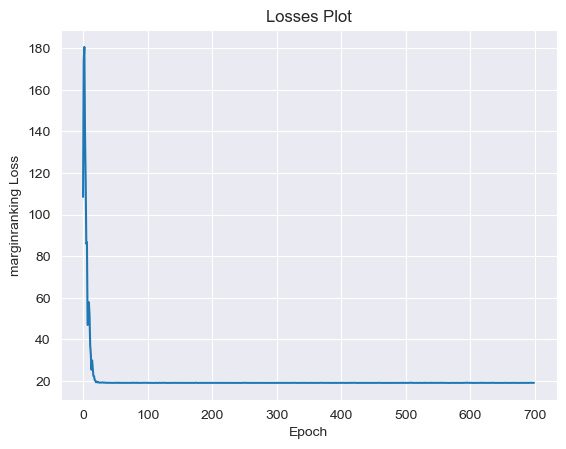

In [11]:
final_model_RESCAL_single.plot_losses()

In [12]:
test_triples

tensor([[33, 17, 27],
        [25, 21, 29],
        [15, 17, 27],
        [15, 24, 11],
        [ 4, 23, 33],
        [32, 21, 29],
        [ 4, 26, 10],
        [24,  5, 17],
        [35,  9, 15],
        [24, 22, 27],
        [19, 15, 15],
        [16, 13, 34],
        [15,  0,  8],
        [ 8,  5, 17],
        [ 8, 17, 27],
        [31,  3, 25]])

In [24]:
train_triples

tensor([[28, 17, 27],
        [ 1,  2,  3],
        [29, 20, 27],
        [13, 26, 10],
        [12, 24, 11],
        [17, 26, 10],
        [22, 17, 27],
        [ 8, 24, 11],
        [33,  4, 27],
        [20, 22, 27],
        [23, 22, 27],
        [30, 28, 22],
        [11, 12,  8],
        [20, 19, 36],
        [ 8, 12,  8],
        [33, 21, 29],
        [17, 17, 27],
        [27, 28, 22],
        [ 4, 25, 25],
        [17, 12,  8],
        [21, 17, 27],
        [ 3, 16,  4],
        [ 8, 26, 10],
        [19, 17, 27],
        [33,  8, 27],
        [29, 28, 22],
        [12, 11, 15],
        [ 2,  2,  3],
        [31, 25, 25],
        [10, 17, 27],
        [30,  8, 27],
        [31, 17, 27],
        [17, 24, 11],
        [ 4, 24, 11],
        [23, 17, 27],
        [27,  8, 27],
        [ 0,  3, 25],
        [29,  9, 15],
        [27, 18, 27],
        [17,  0,  8],
        [12, 29, 22],
        [21, 22, 27],
        [ 8, 29, 22],
        [11, 26, 10],
        [27, 21, 29],
        [ 

Just to be sure I checked for the overlap in triples between train and test sets

In [26]:
import torch 

# Convert tensors to sets
test_set = set(map(tuple, test_triples.tolist()))
testing_set = set(map(tuple, train_triples.tolist()))

# Check for overlap
overlap = test_set.intersection(testing_set)

if overlap:
    print("There is overlap between the tensors.")
else:
    print("There is no overlap between the tensors.")

There is no overlap between the tensors.


In [13]:
entity_to_id

{'FieldQPlainVectorRegionAPlainNominalA': 0,
 'FieldQPointAPlainIntervalA': 1,
 'FieldQPointAPlainRatioA': 2,
 'FieldQRasterAPlainIntervalA': 3,
 'FieldQRasterAPlainRatioA': 4,
 'FieldQVectorTessellationAPlainNominalA': 5,
 'FieldQVectorTessellationAPlainOrdinalA': 6,
 'ObjectQPlainVectorRegionABooleanA': 7,
 'ObjectQPlainVectorRegionACountA': 8,
 'ObjectQPlainVectorRegionACyclicA': 9,
 'ObjectQPlainVectorRegionAERA': 10,
 'ObjectQPlainVectorRegionAIRA': 11,
 'ObjectQPlainVectorRegionANominalA': 12,
 'ObjectQPlainVectorRegionAOrdinalA': 13,
 'ObjectQPlainVectorRegionAPlainIntervalA': 14,
 'ObjectQPlainVectorRegionAPlainNominalA': 15,
 'ObjectQPlainVectorRegionAPlainOrdinalA': 16,
 'ObjectQPlainVectorRegionAPlainRatioA': 17,
 'ObjectQPointACountA': 18,
 'ObjectQPointAERA': 19,
 'ObjectQPointAIRA': 20,
 'ObjectQPointAPlainIntervalA': 21,
 'ObjectQPointAPlainNominalA': 22,
 'ObjectQPointAPlainOrdinalA': 23,
 'ObjectQPointAPlainRatioA': 24,
 'ObjectQVectorRegionAERA': 25,
 'ObjectQVectorTe

In [17]:
relation_to_id

{'ClipObject2Object': 0,
 'ComputeCountDensityonObject': 1,
 'IDWInterval': 2,
 'IntersectDissolveField2Object': 3,
 'JoinCountAttribute': 4,
 'JoinObjectRatios': 5,
 'KernelDensity': 6,
 'KrigingInterval': 7,
 'LoadCountAmounts': 8,
 'SelectLayerByAttributeTessObjects2': 9,
 'SelectLayerByLocationPlainRegionObjects': 10,
 'SelectLayerByLocationPlainRegionObjectsFieldDist': 11,
 'SelectLayerByLocationTessObject': 12,
 'SelectLayerByLocationTessObjects': 13,
 'SelectLayerByObjectTessObjects': 14,
 'SelectNeighborhoodsByLocationDistPointObject': 15,
 'Slope': 16,
 'SpatialJoinCountTess': 17,
 'SpatialJoinMeanTessCount': 18,
 'SpatialJoinMeanTessRatio': 19,
 'SpatialJoinSumTessCount': 20,
 'SpatialJoinSumTessRatio': 21,
 'SummarizeWithin': 22,
 'ZonalStatisticsMeanInterval': 23,
 'ZonalStatisticsMeanRatio': 24,
 'ZonalStatisticsSize': 25,
 'ZonalStatisticsSumField': 26,
 'addObjectCapacity': 27,
 'convert2PointObjects': 28,
 'makePointObjects': 29}

In [21]:
# Create empty lists for entities and relations
entities = []
relations = []

# Loop through each triple and get the corresponding names
for triple in test_triples:
    entity1 = list(entity_to_id.keys())[list(entity_to_id.values()).index(triple[0].item())]
    entity2 = list(entity_to_id.keys())[list(entity_to_id.values()).index(triple[2].item())]
    relation = list(relation_to_id.keys())[list(relation_to_id.values()).index(triple[1].item())]
    entities.append((entity1, entity2))
    relations.append(relation)

# Create a DataFrame
df_triples_test_labels = pd.DataFrame({'head': [e[0] for e in entities],
                   'relation': relations,
                   'tail': [e[1] for e in entities]})

# Print the DataFrame
df_triples_test_labels 



head  \
0   ObjectQVectorTessellationAPlainIntervalA   
1                    ObjectQVectorRegionAERA   
2     ObjectQPlainVectorRegionAPlainNominalA   
3     ObjectQPlainVectorRegionAPlainNominalA   
4                   FieldQRasterAPlainRatioA   
5         ObjectQVectorTessellationAOrdinalA   
6                   FieldQRasterAPlainRatioA   
7                   ObjectQPointAPlainRatioA   
8    ObjectQVectorTessellationAPlainOrdinalA   
9                   ObjectQPointAPlainRatioA   
10                          ObjectQPointAERA   
11    ObjectQPlainVectorRegionAPlainOrdinalA   
12    ObjectQPlainVectorRegionAPlainNominalA   
13           ObjectQPlainVectorRegionACountA   
14           ObjectQPlainVectorRegionACountA   
15        ObjectQVectorTessellationANominalA   

                                        relation  \
0                           SpatialJoinCountTess   
1                        SpatialJoinSumTessRatio   
2                           SpatialJoinCountTess   
3                       ZonalStatisticsMeanRatio   
4                    ZonalStatisticsMeanInterval   
5                        SpatialJoinSumTessRatio   
6                        ZonalStatisticsSumField   
7                               JoinObjectRatios   
8             SelectLayerByAttributeTessObjects2   
9                                SummarizeWithin   
10  SelectNeighborhoodsByLocationDistPointObject   
11              SelectLayerByLocationTessObjects   
12                             ClipObject2Object   
13                              JoinObjectRatios   
14                          SpatialJoinCountTess   
15                 IntersectDissolveField2Object   

                                        tail  
0           ObjectQVectorTessellationACountA  
1              ObjectQVectorTessellationAERA  
2           ObjectQVectorTessellationACountA  
3               ObjectQPlainVectorRegionAIRA  
4   ObjectQVectorTessellationAPlainIntervalA  
5              ObjectQVectorTessellationAERA  
6               ObjectQPlainVectorRegionAERA  
7       ObjectQPlainVectorRegionAPlainRatioA  
8     ObjectQPlainVectorRegionAPlainNominalA  
9           ObjectQVectorTessellationACountA  
10    ObjectQPlainVectorRegionAPlainNominalA  
11   ObjectQVectorTessellationAPlainNominalA  
12           ObjectQPlainVectorRegionACountA  
13      ObjectQPlainVectorRegionAPlainRatioA  
14          ObjectQVectorTessellationACountA  
15                   ObjectQVectorRegionAERA

In [28]:
for index, row in df_triples_test_labels.iterrows():
    head = row['head']
    relation = row['relation']
    
    # Perform prediction for the current row
    prediction = predict.predict_target(
        model=final_model_RESCAL_single.model,
        head=head,
        relation=relation,
        triples_factory=final_model_RESCAL_single.training
    ).df
    
    # Sort the prediction DataFrame by the "score" column in descending order
    prediction_sorted = prediction.sort_values(by='score', ascending=False)
    
    # Keep the top 10 rows
    top_10_predictions = prediction_sorted.head(10)
    
    # Print the row identifier and top 10 predictions
    print(f"Row: {index}")
    print(top_10_predictions)
    print()

Row: 0
    tail_id        score                               tail_label
27       27  2311.179688         ObjectQVectorTessellationACountA
16       16  1714.107666   ObjectQPlainVectorRegionAPlainOrdinalA
3         3  1670.967041              FieldQRasterAPlainIntervalA
12       12  1628.250122        ObjectQPlainVectorRegionANominalA
17       17  1585.597534     ObjectQPlainVectorRegionAPlainRatioA
0         0  1577.640991    FieldQPlainVectorRegionAPlainNominalA
34       34  1558.536987  ObjectQVectorTessellationAPlainNominalA
31       31  1542.102905       ObjectQVectorTessellationANominalA
28       28  1540.164673        ObjectQVectorTessellationACyclicA
11       11  1537.472656             ObjectQPlainVectorRegionAIRA

Row: 1
    tail_id        score                               tail_label
29       29  3161.974854            ObjectQVectorTessellationAERA
35       35  2727.110840  ObjectQVectorTessellationAPlainOrdinalA
0         0  2624.389160    FieldQPlainVectorRegionAPlainNomi

Since all the results came out perfectly I will test some random ones by hand to check if the loop wokrs correctly. I also qickly checked the result.json, and in fact the Hits@K is 1.0 for tail, so it should predict on the first palce. 


triple: [19, 15, 15]  

19 = 'ObjectQPointAERA'  
15= 'SelectNeighborhoodsByLocationDistPointObject'  
15 =  'ObjectQPlainVectorRegionAPlainNominalA'  

In [32]:
pred_example_R_single = predict.predict_target(
    model=final_model_RESCAL_single.model,
    head='ObjectQPointAERA',
    relation='SelectNeighborhoodsByLocationDistPointObject',
    triples_factory= final_model_RESCAL_single.training,
).df

# sorting by the best match
pred_example_R_single_df = pred_example_R_single.sort_values(by='score', ascending=False)

pred_example_R_single_df =  pred_example_R_single_df.head(10)
pred_example_R_single_df

tail_id        score                               tail_label
15       15  3730.774414   ObjectQPlainVectorRegionAPlainNominalA
4         4  3327.980957                 FieldQRasterAPlainRatioA
12       12  3256.791504        ObjectQPlainVectorRegionANominalA
10       10  3211.378418             ObjectQPlainVectorRegionAERA
0         0  3194.990479    FieldQPlainVectorRegionAPlainNominalA
27       27  3189.993896         ObjectQVectorTessellationACountA
34       34  3186.849121  ObjectQVectorTessellationAPlainNominalA
11       11  3183.833008             ObjectQPlainVectorRegionAIRA
14       14  3176.052246  ObjectQPlainVectorRegionAPlainIntervalA
23       23  3160.028809               ObjectQPointAPlainOrdinalA

In [35]:
# indicating the directory where the file is located  
directory_table = "C:/Users/wlibe/OneDrive/Pulpit/Thesis/final_code/tables"
os.chdir(directory_table)

In [ ]:
pred_example_R_single_df.to_excel('example_1_RESCAL_test_triple_single.xlsx')